In [0]:
# !pip install tensorflow==2.0.0b1

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [0]:
# !wget --no-check-certificate \
#     https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
#     -O /tmp/sunspots.csv

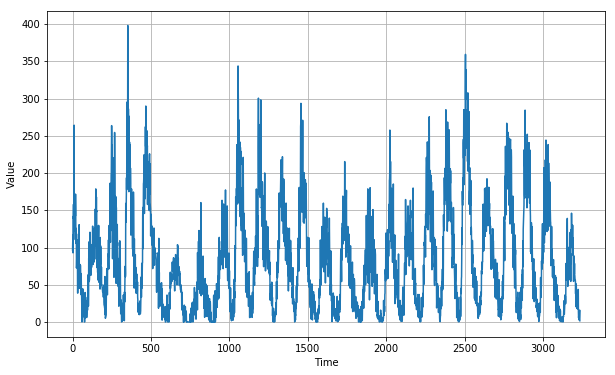

In [6]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

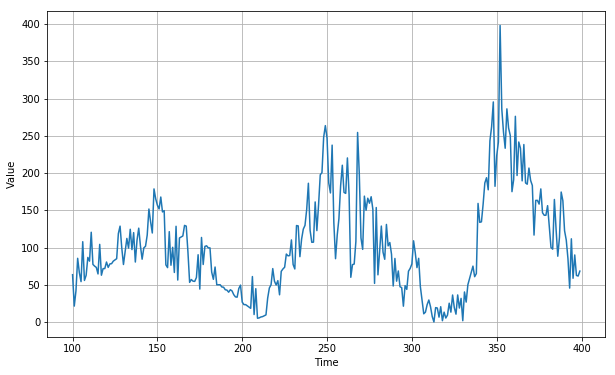

In [7]:
plt.figure(figsize=(10, 6))
plot_series(time, series, start=100, end=400)

In [8]:
len(time)

3235

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # (n, 1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1)) # (m, window_size+1, 1)
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:])) # (m, window_size, 1), (m, winndow_size, 1)
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [15]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(30, activation="relu")),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation="relu")),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

model.summary()





<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 32)          192       
_________________________________________________________________
lstm (LSTM)                  (None, None, 64)          24832     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          33024     
_________________________________________________________________
time_distributed (TimeDistri (None, None, 30)          1950      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          310       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 1)           11        
____________________

In [16]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


12/12 [==============================] - 5s 422ms/step - loss: 33.1539 - mae: 33.4851
Epoch 27/100
12/12 [==============================] - 5s 430ms/step - loss: 32.0168 - mae: 32.3622
Epoch 28/100
12/12 [==============================] - 5s 428ms/step - loss: 31.0499 - mae: 31.4066
Epoch 29/100
12/12 [==============================] - 5s 425ms/step - loss: 30.2567 - mae: 30.6243
Epoch 30/100
12/12 [==============================] - 5s 424ms/step - loss: 29.7006 - mae: 30.0790
Epoch 31/100
12/12 [==============================] - 5s 431ms/step - loss: 29.2809 - mae: 29.6636
Epoch 32/100
12/12 [==============================] - 5s 430ms/step - loss: 28.7719 - mae: 29.1637
Epoch 33/100
12/12 [==============================] - 5s 424ms/step - loss: 28.5344 - mae: 28.9419
Epoch 34/100
12/12 [==============================] - 5s 426ms/step - loss: 28.3927 - mae: 28.8089
Epoch 35/100
12/12 [==============================] - 5s 429ms/step - loss: 28.1421 - mae: 28.5449
Epoch 36/100
12/12 [===

[1e-08, 0.0001, 0, 60]

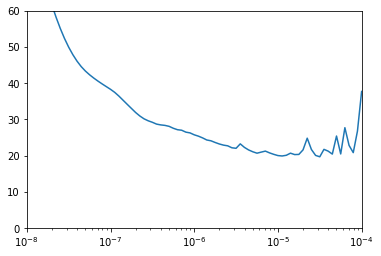

In [17]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(30, activation="relu")),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10, activation="relu")),
  tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 236ms/step - loss: 37.8896 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 5s 153ms/step - loss: 24.3144 - mae: 24.8478
Epoch 3/500
30/30 [==============================] - 4s 147ms/step - loss: 21.0371 - mae: 21.5407
Epoch 4/500
30/30 [==============================] - 5s 151ms/step - loss: 20.2575 - mae: 20.7536
Epoch 5/500
30/30 [==============================] - 4s 150ms/step - loss: 19.6073 - mae: 20.1019
Epoch 6/500
30/30 [==============================] - 4s 146ms/step - loss: 19.3177 - mae: 19.8155
Epoch 7/500
30/30 [==============================] - 4s 148ms/step - loss: 18.7894 - mae: 19.2774
Epoch 8/500
30/30 [==============================] - 5s 151ms/step - loss: 18.7922 - mae: 19.2746
Epoch 9/500
30/30 [==============================] - 5s 153ms/step - loss: 18.4958 - mae: 18.9856
Epoch 10/500
30/30 [==============================] - 5s 152ms/step - loss: 18.3422 - mae: 18.8306
Epoch 11/500
30/30 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

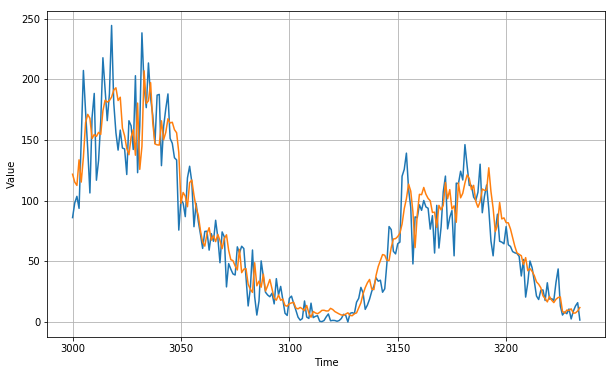

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.12934

<Figure size 432x288 with 0 Axes>

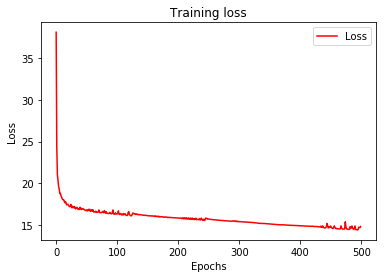

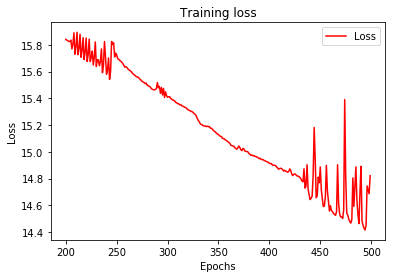

<Figure size 432x288 with 0 Axes>

In [22]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [23]:
print(rnn_forecast)

[121.71841   115.2758    112.513306  133.59048   115.254974  135.81279
 164.29614   171.06102   167.80235   151.09729   154.46027   152.87874
 156.22787   154.5495    173.98257   182.72136   181.17804   182.39362
 185.29735   191.00194   192.94081   182.44756   185.17523   159.7596
 153.41158   143.0428    137.78522   152.33171   158.41661   137.41016
 180.33795   125.757576  144.7751    206.94397   180.02763   182.24251
 197.17365   163.935     146.72223   145.94312   145.75864   165.76178
 150.12813   156.24113   167.4418    163.93463   164.56198   158.44438
 155.8959    139.6865     97.74658   106.70838   103.64013    94.98352
 114.75761   116.96737   104.428825   94.18674    87.87838    75.313255
  65.90282    62.51206    72.71224    77.66391    67.435745   70.952484
  66.206345   72.118744   67.149055   60.415638   68.63677    71.82416
  59.06688    51.33692    50.534046   46.15373    42.87667    59.801586
  40.63453    43.511913   43.899506   31.0576     26.979689   24.368826
  4